# Download Youtube playlists (metadata) using Python

**ToC**

- [Rational](#Rational)
- [Get playlists from Youtube](#Get-playlists-from-Youtube)
- [Store songs in database](#Store-songs-in-database)
- [Search local database](#Search-local-database)

## Rational

So I have a lot playlists on Youtube (20+), some with many video/songs, some with just a few, there is quite an enthropy in there, if I could reduce them to a ~handful of lists I think I would make a better use of them.

So I thought about getting a hand on them through Python and see if I can summarize them (somehow).
At least, I think it is a cool workflow to play with; hopefully something nice and useful comes out of it.

The language is chosen, Python; We will need a database inside to persist the data (otherwise, some json/csv file).
And, at the start, where data is, Youtube' API. Here is the work ahead:

- get (youtube) playlists for a given username/token;
  * playlists are expected to provide songs _id_, _title_, _singer_, _URL_
- store songs in a database;
  * database (v1) has a table _songs_ with the following columns:
    - (song) title
    - (song) URL
    - (song) author/singer
    - (song) id: youtube song unique id
    - playlist id: youtube playlist id
    - tags: song + playlist title tokens/words
- search songs in local database based on:
  * playlist
  * title (free text)
  * author/singer
  * tags
- create/remove playlists

## Get playlists from Youtube

Accessing an API means _study_ and tokens; Besides the public endpoints, accessing private endpoints emplies having permission to access them and the way it is done is typically through some token. 
To know about the token and overall how to access the information you want, studying the API's documentation is a task in the very top.
Some sites provide an HTTP API through a web server endpoints, some provide software libraries (_e.g._, in Python), some provie both; WHich is the case of Youtube.

Youtube API is very well documented, you will find at https://developers.google.com/youtube/v3 many resources providing different levels on the API's use, including code samples in different languages.
The Python Code Samples page provides apparently all the information/links we need to do our job.

In the instructions on how to run the code sample, https://developers.google.com/explorer-help/guides/code_samples, it is explained where to get the code samples and how to run them, including the prerequisites like libraries and authentication information:

> Your credentials will be one of the following, depending on the sample in question:
>
> - an API key
> - a client_secret.json file containing your OAuth 2.0 client ID and client secret
> - an OAuth 2.0 access token

For Python, install Google's API/authentication libraries:

```bash
$ pip install --upgrade google-api-python-client
$ pip install --upgrade google-auth-oauthlib google-auth-httplib2
```

### Running sample code

Before running any code sample, as described in the "Code Samples" page, we have to set the API permissions for this access,

> 1. Create or select a project in the [API Console](https://console.developers.google.com/). Complete the following tasks in the API Console for your project:
>
>   - In the [library panel](https://console.developers.google.com/apis/library), search for the API you are calling and make sure it is enabled for your project.
>   - In the [credentials panel](https://console.developers.google.com/apis/credentials), either create an API key or create an OAuth 2.0 client ID and set the application type to Other. Note that some API requests require OAuth 2.0 authorization.

We go there and:
1. _create_ the project "Youtube playlist", then
2. _enable_ "youtube data api v3" for this project, and
3. _create credentials_ for this API (selecting "User data").

During the creadentials creation I went through a series of steps to create an "app" for accessing the information, eventually a _Client ID_ token was provided.

> When you define _scopes_, **make sure** to allow for "/auth/youtube.readonly
> 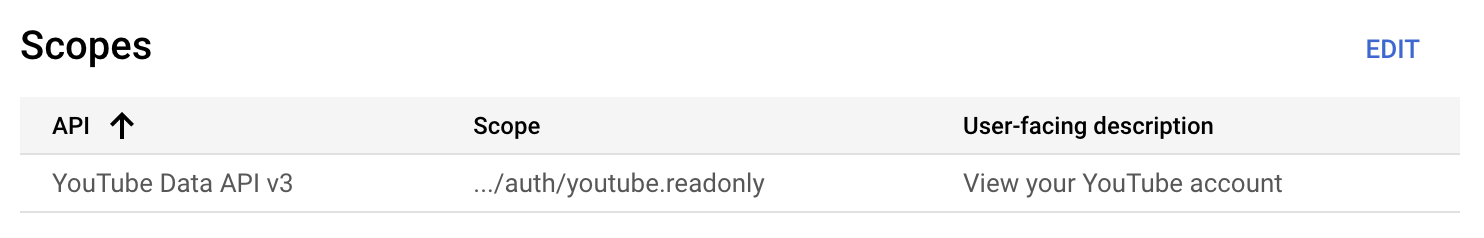

> Also, make sure to define the users (email) in the list of "test users" authorized

The credentials created cat be downloaded in the _credentials panel_ (where you now should the just-created "app"),
from there you can download the json file expected by the API.
As of the time of this writing, the file has the following content

```json
{
  "installed":{
    "client_id": <google-client-id>,
    "client_secret": <google-client-secret>,
    "project_id": <google-project-id>,
    "auth_uri":"https://accounts.google.com/o/oauth2/auth",
    "token_uri":"https://oauth2.googleapis.com/token",
    "auth_provider_x509_cert_url":"https://www.googleapis.com/oauth2/v1/certs",
    "redirect_uris":["urn:ietf:wg:oauth:2.0:oob","http://localhost"]
  }
}
```

Once that is done, we go for the code sample. In the page,, we look for things relating to "playlist" and get:

```python
# -*- coding: utf-8 -*-

# Sample Python code for youtube.channels.list
# See instructions for running these code samples locally:
# https://developers.google.com/explorer-help/guides/code_samples#python

import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

def main():
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = "YOUR_CLIENT_SECRET_FILE.json"

    # Get credentials and create an API client
    flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
        client_secrets_file, scopes)
    credentials = flow.run_console()
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

    request = youtube.channels().list(
        part="snippet,contentDetails",
        maxResults=25,
        mine=True
    )
    response = request.execute()

    print(response)

if __name__ == "__main__":
    main()
```

Code that we modify to use our `client_secrets_file`, and run.
The output is a list of channels (notice `request = youtube.channels().list`). 

A list of channels is not what we are looking for as _data_, but the fact that it works is a very good start.
Our goal is: "playlists and songs therein".

### Get playlists

Playlists are provided by youtube-client's [`playlists()`](https://developers.google.com/youtube/v3/docs/playlists) method. 
Likewise, playlists' items come through the [`playlistItems()`](https://developers.google.com/youtube/v3/docs/playlistItems) endpoint.

Go on their docs and learn about the `list()` methods; here are the ones we'll use:

- `maxResults`: maximum number of items to return (max 50)
- (`playlistItems`) `playlistId`: playlist's unique ID to get songs from

In the [items returned](https://developers.google.com/youtube/v3/docs/playlistItems#resource), we are particularly interested in the following schema:

```json
{
  "kind": "youtube#playlistItem",
  "id": 'string',
  "snippet": {
    "title": 'string',
    "description": 'string',
    "videoOwnerChannelTitle": 'string',
    "videoOwnerChannelId": 'string',
    "playlistId": 'string',
    "position": 'unsigned integer',
  },
  "contentDetails": {
    "videoId": 'string',
    "note": 'string',
    "videoPublishedAt": 'datetime'
  },
  "status": {
    "privacyStatus": 'string'
  }
}
```

Whereas from playlists we don't want much (if anything actually):
```json
{
  "kind": "youtube#playlist",
  "etag": 'etag',
  "id": 'string',
  "snippet": {
    "title": 'string',
    "description": 'string',
  }
}
```

In [1]:
# -*- coding: utf-8 -*-

# Sample Python code for youtube.channels.list
# See instructions for running these code samples locally:
# https://developers.google.com/explorer-help/guides/code_samples#python

import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

def authenticate(client_secrets_file = "client_secret.json"):
    """Return authenticated client"""
    from google_auth_oauthlib.flow import InstalledAppFlow
    from googleapiclient.discovery import build as build_client
    
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"

    # Get credentials and create an API client
    flow = InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
    credentials = flow.run_console()
    youtube = build_client(api_service_name, api_version, credentials=credentials)
    
    return youtube


def get_playlists(youtube_client):
    """Return playlists json"""
    obj = youtube_client.playlists
    items = _get_items(obj, mine=True)
    return items

def get_playlist_items(playlistId, youtube_client):
    """Return playlist items json"""
    obj = youtube_client.playlistItems
    items = _get_items(obj, playlistId=playlistId)
    return items

def _get_items(obj, **kwargs):
    """Return obj's list() response"""
    request = obj().list(
        part="snippet,contentDetails,status",
        maxResults=1000,
        **kwargs
    )
    response = request.execute()
    return response


#     request = youtube.playlistItems().list(
#         part="snippet,contentDetails",
#         playlistId=playlist_id,
#         maxResults=maxResults
#     )


In [2]:
client = authenticate()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=100321054629-mkjng4r3g2t97n7g9snn31sg08n83gi2.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=KjRTBZWwXISCHg9v3BaYAOaqcW0kRD&prompt=consent&access_type=offline
Enter the authorization code: 4/1AX4XfWjeO9rggEpVkn-vhIaboZBxtNZbi81T4S8kYaSCnyJBR2Klx-XBc7I


In [3]:
playlists = get_playlists(client)
playlists

{'kind': 'youtube#playlistListResponse',
 'etag': 'rCE-nKQlYfi50gMR7geNjI-Prqw',
 'nextPageToken': 'CDIQAA',
 'pageInfo': {'totalResults': 187, 'resultsPerPage': 50},
 'items': [{'kind': 'youtube#playlist',
   'etag': 'OgVGpfQhSABa3ULpHGgwytg1arI',
   'id': 'PL5GD-IZK8YTTOeEPdKQXWcxwOVe4SyiN7',
   'snippet': {'publishedAt': '2021-11-07T15:25:20Z',
    'channelId': 'UCZpTfQMCXgyCPavL3TZwtRA',
    'title': '[music] chill',
    'description': '',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/hqdefault.jpg',
      'width': 480,
      'height': 360},
     'standard': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/sddefault.jpg',
      'width': 640,
      'height': 480},
     'maxres': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/maxresdefault

Notice the resource's top information (we may use that to get all the results from the other _pages_):
- `'nextPageToken': 'CDIQAA'`
- `'pageInfo': {'totalResults': 187, 'resultsPerPage': 50}`

In [4]:
pl_names = [ pl['snippet']['title'] 
            for pl in playlists['items'] ]

music_lists = [name for name in pl_names 
               if '[music]' in name]
music_lists

['[music] chill',
 '[music] mpb',
 '[music] Best of all times',
 '[music] jukebox',
 '[music] beat-pop br',
 '[music] beats']

In [5]:
import copy
def _copy_values_from_schema(obj_reference: dict, obj_response: dict):
    """Select values from 'response' based on 'reference' schema"""
    _obj = {}
    for ref_field in obj_reference:
        ref_data = obj_reference[ref_field]
        resp_data = obj_response[ref_field]
        if isinstance(ref_data, dict):
            resp_data = _copy_values_from_schema(ref_data, copy.copy(resp_data))
        _obj[ref_field] = resp_data
    return _obj

def parse_items_from_schema(obj_reference: dict, items_response: list):
    """Return list of objects with same structure of 'reference' but values from 'response' items"""
    _items = []
    for obj_item in items_response:
        _item = _copy_values_from_schema(obj_reference, obj_item)
        _items.append(_item)
    return _items

In [6]:
ref = {
  "kind": "youtube#playlist",
  "etag": 'etag',
  "id": 'string',
  "snippet": {
    "title": 'string',
    "description": 'string',
  },
}

playlists['items'] = parse_items_from_schema(ref, playlists['items'])

In [7]:
for item in playlists['items']:
    pl_id = item['id']
    pl_title = item['snippet']['title']
    if '[music]' in pl_title:
        print(pl_id, pl_title)

PL5GD-IZK8YTTOeEPdKQXWcxwOVe4SyiN7 [music] chill
PL5GD-IZK8YTTRmQGnxwJekVU_9aYsC8-F [music] mpb
PL5GD-IZK8YTRs_sXcQ63kMKgik4hzts7m [music] Best of all times
PL5GD-IZK8YTRt9UyRLfIftPr6APDxcWS5 [music] jukebox
PL5GD-IZK8YTS23PX1OzeG1p1j-m-a5uW9 [music] beat-pop br
PL5GD-IZK8YTTmZSkXZJy4hJisVFKItdcD [music] beats


In [8]:
pl_id = 'PL5GD-IZK8YTTOeEPdKQXWcxwOVe4SyiN7'
playlistItems = get_playlist_items(pl_id, client)
playlistItems

{'kind': 'youtube#playlistItemListResponse',
 'etag': 'dL4iko7_ybdWDBUS1cfPUR4e4nE',
 'items': [{'kind': 'youtube#playlistItem',
   'etag': 'rGMNMaAgFRxzHE357VMDnzLDpts',
   'id': 'UEw1R0QtSVpLOFlUVE9lRVBkS1FYV2N4d09WZTRTeWlONy41NkI0NEY2RDEwNTU3Q0M2',
   'snippet': {'publishedAt': '2021-11-07T15:25:20Z',
    'channelId': 'UCZpTfQMCXgyCPavL3TZwtRA',
    'title': 'Cumbia del Olvido',
    'description': 'Provided to YouTube by BWSCD Inc\n\nCumbia del Olvido · Nicola Cruz\n\nPrender el Alma\n\n℗ 2015 ZZK Records\n\nReleased on: 2015-10-30\n\nMain  Artist: Nicola Cruz\n\nAuto-generated by YouTube.',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/DGR_A47PN24/hqdefault.jpg',
      'width': 480,
      'height': 360},
     'standard': {'url': 'https://i.y

In [9]:
item_id = playlistItems['items'][0]['contentDetails']['videoId']

print(f'https://youtube.com/watch?v={item_id}')

https://youtube.com/watch?v=DGR_A47PN24


In [10]:
playlistItems_ref = {
  "kind": "youtube#playlistItem",
  "id": 'string',
  "snippet": {
    "title": 'string',
    "description": 'string',
    "videoOwnerChannelTitle": 'string',
    "videoOwnerChannelId": 'string',
    "playlistId": 'string',
    "position": 'unsigned integer',
  },
  "contentDetails": {
    "videoId": 'string',
    "videoPublishedAt": 'datetime'
  },
  "status": {
    "privacyStatus": 'string'
  }
}

parse_items_from_schema(playlistItems_ref, playlistItems['items'])

[{'kind': 'youtube#playlistItem',
  'id': 'UEw1R0QtSVpLOFlUVE9lRVBkS1FYV2N4d09WZTRTeWlONy41NkI0NEY2RDEwNTU3Q0M2',
  'snippet': {'title': 'Cumbia del Olvido',
   'description': 'Provided to YouTube by BWSCD Inc\n\nCumbia del Olvido · Nicola Cruz\n\nPrender el Alma\n\n℗ 2015 ZZK Records\n\nReleased on: 2015-10-30\n\nMain  Artist: Nicola Cruz\n\nAuto-generated by YouTube.',
   'videoOwnerChannelTitle': 'Nicola Cruz - Topic',
   'videoOwnerChannelId': 'UCdMtd-AdeTlVGNThheAyEKw',
   'playlistId': 'PL5GD-IZK8YTTOeEPdKQXWcxwOVe4SyiN7',
   'position': 0},
  'contentDetails': {'videoId': 'DGR_A47PN24',
   'videoPublishedAt': '2021-05-18T21:00:28Z'},
  'status': {'privacyStatus': 'public'}},
 {'kind': 'youtube#playlistItem',
  'id': 'UEw1R0QtSVpLOFlUVE9lRVBkS1FYV2N4d09WZTRTeWlONy4yODlGNEE0NkRGMEEzMEQy',
  'snippet': {'title': 'Third Eye Dub (Original Mix)',
   'description': 'Provided to YouTube by Label Worx Ltd\n\nThird Eye Dub (Original Mix) · Nicola Cruz · Nasiri\n\nHybridism\n\n℗ Multi Cult

In [11]:
songs = []
for playlist in playlists['items']:

    pl_title = playlist['snippet']['title']
    if not '[music]' in pl_title:
        continue

    pl_id = playlist['id']
    playlistItems = get_playlist_items(pl_id, client)
    
    # Tagging is being done poorly sofar, just the word from the playlist name,
    # so every song in this playlist is getting the same tag(s)
    tags = ','.join([t for t in pl_title.replace('[music]','').strip().split() if len(t) > 2])
    
    for song in playlistItems['items']:
        song_id = song['contentDetails']['videoId']
        url = f'https://youtube.com/watch?v={song_id}'
        song_title = song['snippet']['title']
        channel_owner = song['snippet']['videoOwnerChannelTitle']
        songs.append((song_title,url,channel_owner, pl_title, tags))

In [12]:
songs

[('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  'Nicola Cruz - Topic',
  '[music] chill',
  'chill'),
 ('Third Eye Dub (Original Mix)',
  'https://youtube.com/watch?v=m8CDzLarV4Y',
  'Nicola Cruz - Topic',
  '[music] chill',
  'chill'),
 ('Cumbia Sobre el Mar',
  'https://youtube.com/watch?v=f1qTRHGqaQI',
  'Quantic - Topic',
  '[music] chill',
  'chill'),
 ('Canto de Oxum / Inscrição',
  'https://youtube.com/watch?v=S8XzYCdaxRQ',
  'Maria Bethânia - Topic',
  '[music] chill',
  'chill'),
 ('Amanecer',
  'https://youtube.com/watch?v=jSWzZQrF3dk',
  'Danit - Topic',
  '[music] chill',
  'chill'),
 ('Voz de las Montañas (con Minük)',
  'https://youtube.com/watch?v=rfDVOjmOjBo',
  'Nicola Cruz - Topic',
  '[music] chill',
  'chill'),
 ('Gajumaru',
  'https://youtube.com/watch?v=fUclh2JkMr8',
  'Yaima - Topic',
  '[music] chill',
  'chill'),
 ('Beautiful Tango (Unplugged)',
  'https://youtube.com/watch?v=G5qYaeIRob8',
  'Hindi Zahra - Topic',
  '[music] chill',
  'chi

## Store songs in database

As previously planned we need a table for all the songs, containing the values we have retrieved.

Thinking on storing our songs notice that tags have a relation, possibly, of many to one: when we'll search for "songs with _Tag_" we'll (possibly) get many songs, and vie-versa, a song (may) be associated to many tags.
To decide how we will store that information -- tags/song -- it seems helpful to think how we will use it.

The search for songs per tag is a search on which songs have a tag "Tag" which makes us think on a table oriented for the tags with records being _tag_-_song_ tuples (per song per tag). A flat table, essencially, with (possibly) many duplicated tag values as well as song (ids), but the tuples (tag-song) for a unique set.

Vice-versa, the search for tags per song is easy to realize when we think of a/the table that is song-oriented:
a column with associated tags split-printed would answer that.
But _updating_ such hard-coded field, in the event of updating some tag name or association for example, seems to be a rather costly process.

As such, we need two tables, one for the songs and one for the tags.

The table `songs` has the following setup:

- `song_title`: string
- `youtube_url`: string
- `video_id`: string
- `playlist_title`: string
- `channel_owner`: string

And the `tags` table:

- `tag`: string
- `video_id`: string

For simplicity, we are going to use SQLite (through Python's `sqlite3` library).

In [13]:
import sqlite3
con = sqlite3.connect('youtube_playlists.db')

In [14]:
# Create the table
cur = con.cursor()

# Create table songs
cur.execute('''CREATE TABLE IF NOT EXISTS songs (
                    song_title text, 
                    youtube_url text,
                    video_id text, 
                    playlist_title text, 
                    channel_owner text
                )'''
           )

# Create table songs
cur.execute('''CREATE TABLE IF NOT EXISTS tags (
                    video_id text, 
                    song_tag text
                )'''
           )

con.commit()

In [15]:
# Format/create the tuples to INSERT in our table
songs_insert = []
tags_insert = []
for song in songs:
    title, url, owner, playlist, tags_string = song
    video_id = url.split('v=')[-1]
    songs_insert.append((title, url, video_id, playlist, owner))
    tags = tags_string.split(',')
    for tag in tags:
        tags_insert.append((video_id,tag))

In [16]:
songs_insert

[('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  'DGR_A47PN24',
  '[music] chill',
  'Nicola Cruz - Topic'),
 ('Third Eye Dub (Original Mix)',
  'https://youtube.com/watch?v=m8CDzLarV4Y',
  'm8CDzLarV4Y',
  '[music] chill',
  'Nicola Cruz - Topic'),
 ('Cumbia Sobre el Mar',
  'https://youtube.com/watch?v=f1qTRHGqaQI',
  'f1qTRHGqaQI',
  '[music] chill',
  'Quantic - Topic'),
 ('Canto de Oxum / Inscrição',
  'https://youtube.com/watch?v=S8XzYCdaxRQ',
  'S8XzYCdaxRQ',
  '[music] chill',
  'Maria Bethânia - Topic'),
 ('Amanecer',
  'https://youtube.com/watch?v=jSWzZQrF3dk',
  'jSWzZQrF3dk',
  '[music] chill',
  'Danit - Topic'),
 ('Voz de las Montañas (con Minük)',
  'https://youtube.com/watch?v=rfDVOjmOjBo',
  'rfDVOjmOjBo',
  '[music] chill',
  'Nicola Cruz - Topic'),
 ('Gajumaru',
  'https://youtube.com/watch?v=fUclh2JkMr8',
  'fUclh2JkMr8',
  '[music] chill',
  'Yaima - Topic'),
 ('Beautiful Tango (Unplugged)',
  'https://youtube.com/watch?v=G5qYaeIRob8',
  'G5qYa

In [17]:
tags_insert

[('DGR_A47PN24', 'chill'),
 ('m8CDzLarV4Y', 'chill'),
 ('f1qTRHGqaQI', 'chill'),
 ('S8XzYCdaxRQ', 'chill'),
 ('jSWzZQrF3dk', 'chill'),
 ('rfDVOjmOjBo', 'chill'),
 ('fUclh2JkMr8', 'chill'),
 ('G5qYaeIRob8', 'chill'),
 ('Mgi-jN4KIBk', 'chill'),
 ('4ndQZgX6r7Q', 'chill'),
 ('lCeprD4gInk', 'chill'),
 ('2JM9sHXJDlU', 'chill'),
 ('TZp_nGMj6GE', 'chill'),
 ('qnbko7EW9_I', 'mpb'),
 ('p5OI0YlcSXs', 'mpb'),
 ('lBLrFeSznsM', 'mpb'),
 ('Hl5idWgmHEA', 'mpb'),
 ('Kte__GAcSVU', 'mpb'),
 ('CTGJUeDupRg', 'mpb'),
 ('ETt4oW0dM1s', 'Best'),
 ('ETt4oW0dM1s', 'all'),
 ('ETt4oW0dM1s', 'times'),
 ('Mf_5l1yTKNY', 'Best'),
 ('Mf_5l1yTKNY', 'all'),
 ('Mf_5l1yTKNY', 'times'),
 ('R6RD6mjiIZE', 'jukebox'),
 ('ETt4oW0dM1s', 'jukebox'),
 ('sjLfAeztuzM', 'beat-pop'),
 ('UcTvKpkLBzc', 'beats'),
 ('yCdTn_ZjBQY', 'beats'),
 ('q0hyYWKXF0Q', 'beats'),
 ('8EotiQPnouw', 'beats'),
 ('XU-jAGH6OE4', 'beats'),
 ('rKTUAESacQM', 'beats'),
 ('DGR_A47PN24', 'beats')]

In [18]:
cur.executemany("INSERT INTO songs VALUES (?,?,?,?,?)", songs_insert)

In [19]:
cur.executemany("INSERT INTO tags VALUES (?,?)", tags_insert)

In [20]:
con.commit()

## Search local database

In [21]:
cur.execute('SELECT * FROM songs')

In [22]:
songs_retrieved = cur.fetchall()
songs_retrieved

[('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  'DGR_A47PN24',
  '[music] chill',
  'Nicola Cruz - Topic'),
 ('Third Eye Dub (Original Mix)',
  'https://youtube.com/watch?v=m8CDzLarV4Y',
  'm8CDzLarV4Y',
  '[music] chill',
  'Nicola Cruz - Topic'),
 ('Cumbia Sobre el Mar',
  'https://youtube.com/watch?v=f1qTRHGqaQI',
  'f1qTRHGqaQI',
  '[music] chill',
  'Quantic - Topic'),
 ('Canto de Oxum / Inscrição',
  'https://youtube.com/watch?v=S8XzYCdaxRQ',
  'S8XzYCdaxRQ',
  '[music] chill',
  'Maria Bethânia - Topic'),
 ('Amanecer',
  'https://youtube.com/watch?v=jSWzZQrF3dk',
  'jSWzZQrF3dk',
  '[music] chill',
  'Danit - Topic'),
 ('Voz de las Montañas (con Minük)',
  'https://youtube.com/watch?v=rfDVOjmOjBo',
  'rfDVOjmOjBo',
  '[music] chill',
  'Nicola Cruz - Topic'),
 ('Gajumaru',
  'https://youtube.com/watch?v=fUclh2JkMr8',
  'fUclh2JkMr8',
  '[music] chill',
  'Yaima - Topic'),
 ('Beautiful Tango (Unplugged)',
  'https://youtube.com/watch?v=G5qYaeIRob8',
  'G5qYa

In [23]:
cur.execute('SELECT * FROM songs JOIN tags ON songs.video_id = tags.video_id')
songs_full_retrieved = cur.fetchall()
songs_full_retrieved

[('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  'DGR_A47PN24',
  '[music] chill',
  'Nicola Cruz - Topic',
  'DGR_A47PN24',
  'beats'),
 ('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  'DGR_A47PN24',
  '[music] chill',
  'Nicola Cruz - Topic',
  'DGR_A47PN24',
  'beats'),
 ('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  'DGR_A47PN24',
  '[music] chill',
  'Nicola Cruz - Topic',
  'DGR_A47PN24',
  'chill'),
 ('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  'DGR_A47PN24',
  '[music] chill',
  'Nicola Cruz - Topic',
  'DGR_A47PN24',
  'chill'),
 ('Third Eye Dub (Original Mix)',
  'https://youtube.com/watch?v=m8CDzLarV4Y',
  'm8CDzLarV4Y',
  '[music] chill',
  'Nicola Cruz - Topic',
  'm8CDzLarV4Y',
  'chill'),
 ('Third Eye Dub (Original Mix)',
  'https://youtube.com/watch?v=m8CDzLarV4Y',
  'm8CDzLarV4Y',
  '[music] chill',
  'Nicola Cruz - Topic',
  'm8CDzLarV4Y',
  'chill'),
 ('Cumbia Sobre el Mar',
  'ht

In [24]:
cur.execute("""
    SELECT song_title, youtube_url, playlist_title, channel_owner, 
            GROUP_CONCAT(DISTINCT song_tag) AS tags_concat
    FROM songs
    JOIN tags ON songs.video_id = tags.video_id
    GROUP BY songs.video_id
    """)
songs_join_retrieved = cur.fetchall()
songs_join_retrieved

[('Tzen Tze Re Rei',
  'https://youtube.com/watch?v=2JM9sHXJDlU',
  '[music] chill',
  'Loli Cosmica - Topic',
  'chill'),
 ('Cuatro Vientos',
  'https://youtube.com/watch?v=4ndQZgX6r7Q',
  '[music] chill',
  'Danit - Topic',
  'chill'),
 ('Stay Home & Chill Vol. 6',
  'https://youtube.com/watch?v=8EotiQPnouw',
  '[music] beats',
  'S!X - Music',
  'beats'),
 ('Caetano Veloso, Moreno Veloso - Deusa Do Amor (Ao Vivo)',
  'https://youtube.com/watch?v=CTGJUeDupRg',
  '[music] mpb',
  'CaetanoVelosoVEVO',
  'mpb'),
 ('Cumbia del Olvido',
  'https://youtube.com/watch?v=DGR_A47PN24',
  '[music] chill',
  'Nicola Cruz - Topic',
  'beats,chill'),
 ('Bang Bang (My Baby Shot Me Down)',
  'https://youtube.com/watch?v=ETt4oW0dM1s',
  '[music] Best of all times',
  'Daniela Andrade',
  'Best,all,jukebox,times'),
 ('Beautiful Tango (Unplugged)',
  'https://youtube.com/watch?v=G5qYaeIRob8',
  '[music] chill',
  'Hindi Zahra - Topic',
  'chill'),
 ('Não dá mais / Ela me faz - Rael (VERSÃO por Helena B

In [25]:
import pandas
songs = pandas.DataFrame(songs_join_retrieved,
                         columns=['title','url','playlist','owner','tags'])

songs

,title,url,playlist,owner,tags
0,Tzen Tze Re Rei,https://youtube.com/watch?v=2JM9sHXJDlU,[music] chill,Loli Cosmica - Topic,chill
1,Cuatro Vientos,https://youtube.com/watch?v=4ndQZgX6r7Q,[music] chill,Danit - Topic,chill
2,Stay Home & Chill Vol. 6,https://youtube.com/watch?v=8EotiQPnouw,[music] beats,S!X - Music,beats
3,"Caetano Veloso, Moreno Veloso - Deusa Do Amor ...",https://youtube.com/watch?v=CTGJUeDupRg,[music] mpb,CaetanoVelosoVEVO,mpb
4,Cumbia del Olvido,https://youtube.com/watch?v=DGR_A47PN24,[music] chill,Nicola Cruz - Topic,"beats,chill"
5,Bang Bang (My Baby Shot Me Down),https://youtube.com/watch?v=ETt4oW0dM1s,[music] Best of all times,Daniela Andrade,"Best,all,jukebox,times"
6,Beautiful Tango (Unplugged),https://youtube.com/watch?v=G5qYaeIRob8,[music] chill,Hindi Zahra - Topic,chill
7,Não dá mais / Ela me faz - Rael (VERSÃO por He...,https://youtube.com/watch?v=Hl5idWgmHEA,[music] mpb,Helena Badari,mpb
8,Reconvexo (Ao Vivo),https://youtube.com/watch?v=Kte__GAcSVU,[music] mpb,Maria Bethânia - Topic,mpb
9,Nina Simone - Stars / Feelings (Medley / Live ...,https://youtube.com/watch?v=Mf_5l1yTKNY,[music] Best of all times,NinaSimoneVEVO,"Best,all,times"


### Search for musics with _Tag_

First we need to know which tags are available to then search for musics associated with it

In [26]:
# List tags
def list_tags():
    cur.execute("SELECT DISTINCT song_tag FROM tags")
    result = cur.fetchall()
    return [t for st in result for t in st]

list_tags()

['chill', 'mpb', 'Best', 'all', 'times', 'jukebox', 'beat-pop', 'beats']

In [27]:
# Get the songs with a tag. To change a little bit, let's get that using Pandas
tag_select = 'chill'

# pandas.read_sql_query(f"""
#     SELECT *
#     FROM tags
#     WHERE song_tag = '{tag_select}'
#     """, con)

pandas.read_sql_query(f"""
    SELECT song_title, youtube_url, playlist_title
    FROM songs
    JOIN (SELECT DISTINCT tags.video_id FROM tags WHERE song_tag = '{tag_select}') AS t
    ON songs.video_id = t.video_id
    GROUP BY song_title
    """, con)

,song_title,youtube_url,playlist_title
0,Amanecer,https://youtube.com/watch?v=jSWzZQrF3dk,[music] chill
1,Beautiful Tango (Unplugged),https://youtube.com/watch?v=G5qYaeIRob8,[music] chill
2,Canto de Oxum / Inscrição,https://youtube.com/watch?v=S8XzYCdaxRQ,[music] chill
3,Cuatro Vientos,https://youtube.com/watch?v=4ndQZgX6r7Q,[music] chill
4,Cumbia Sobre el Mar,https://youtube.com/watch?v=f1qTRHGqaQI,[music] chill
5,Cumbia del Olvido,https://youtube.com/watch?v=DGR_A47PN24,[music] chill
6,Cuñaq (Mose Remix),https://youtube.com/watch?v=Mgi-jN4KIBk,[music] chill
7,Gabor Szabo - Galatea's Guitar,https://youtube.com/watch?v=TZp_nGMj6GE,[music] chill
8,Gajumaru,https://youtube.com/watch?v=fUclh2JkMr8,[music] chill
9,Guacamayo,https://youtube.com/watch?v=lCeprD4gInk,[music] chill


In [28]:
con.close()